# Gaussian Mixture Models

$$
\begin{align}
    p({\bf x}) &= \sum_{{\bf z}}p({\bf z})p({\bf x}|{\bf z})\\
               &= \sum_{k}\pi_k \mathcal{N}({\bf x}|{\boldsymbol \mu}_k, {\boldsymbol \Sigma}_k)
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from numpy.random import randn, seed
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap

points_cmap = ListedColormap(["Yellow", "Red"])

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=3, suppress=True)

## The EM Algorithm
Given a GMM, the goal is to maximize the likelilhood function w.r.t. the parameters

1. Initialize the means $\boldsymbol \mu_k$, covariances $\boldsymbol \Sigma_k$ and mixing coefficients $\pi_k$, and evaluate the initial value of the log likelihood

2. **E Step**: Evaluate the responsibilites using the current parameter values
$$
    p(z_k=1|{\bf x}) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N}({\bf x}_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)}{\sum_{j=1}^K\pi_j \mathcal{N}({\bf x}_n|\boldsymbol \mu_j, \boldsymbol \Sigma_j)}
$$

3. **M Step**: Re-estimate the parameters using the current probabilities

$$
    \boldsymbol\mu_{k}^{\text{new}} = \frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk}) {\bf x}_n
$$

$$
    \boldsymbol{\Sigma}_k^{\text{new}} = \frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk}) ({\bf x}_n - \boldsymbol\mu_{k}^{\text{new}})({\bf x}_n - \boldsymbol\mu_{k}^{\text{new}})^T
$$

$$
    \pi_k^{\text{new}} = \frac{N_k}{N}
$$

Where $N_K = \sum_{n=1}^N \gamma(z_{nk})$

4. Evaluate the log likelihood and check for convergence of either the parameters or the log likelihood. If convergence is not met return to step 2.

$$
    \log p({\bf X}|\boldsymbol\mu, \boldsymbol\Sigma, \boldsymbol\pi) = \sum_{n=1}^N \log\left(\sum_{k=1}^K\pi_k \mathcal{N}({\bf x}_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\right)
$$

With

* $\mathcal{N}(x|\mu, \sigma^2) = (2\pi)^{-M/2}|\Sigma|^{-1/2}\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right)$

---- 

**Note**:  
* The covariance matrices can conviniently be initialized to the sample covariances of the clusters found by the K-means algorithm, and
* the mixing coeffients can be set to the fractions of data points assigned to the respective clusters

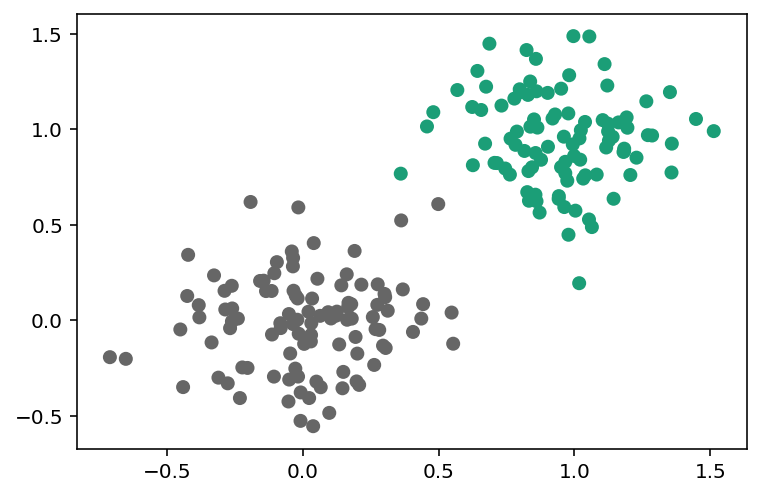

In [3]:
X, y, _ = make_biclusters((200, 2), 2, noise=0.24, random_state=314, minval=0, maxval=1)
plt.scatter(*X.T, c=y.argmax(axis=0), cmap="Dark2")

In [4]:
classes = np.array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1]).astype(bool)

In [5]:
def covariance(X):
    """
    Parameters
    ----------
    X: np.array(N, M)
        Array with N real-valued observations with vectors
        of size M
    """
    X = X.T
    M, N = X.shape
    mu = X.mean(axis=1, keepdims=True)
    cov = X - mu
    cov = cov @ cov.T / (N - 1)
    return cov

def correlation(X):
    cov = covariance(X)
    sigmas = X.T.std(axis=1, ddof=1)
    sigmas = np.outer(sigmas, sigmas)
    return cov / sigmas

In [6]:
N = len(X)
k1 = X[~classes]
k2 = X[classes]

In [7]:
# Can start anywhere we want
mu1 = np.array([-0.2, 1])
mu2 = np.array([ 1, 0.3])

In [8]:
Sigma1 = covariance(k1)
Sigma2 = covariance(k2)

In [9]:
pi1 = len(k1) / len(X)
pi2 = len(k2) / len(X)

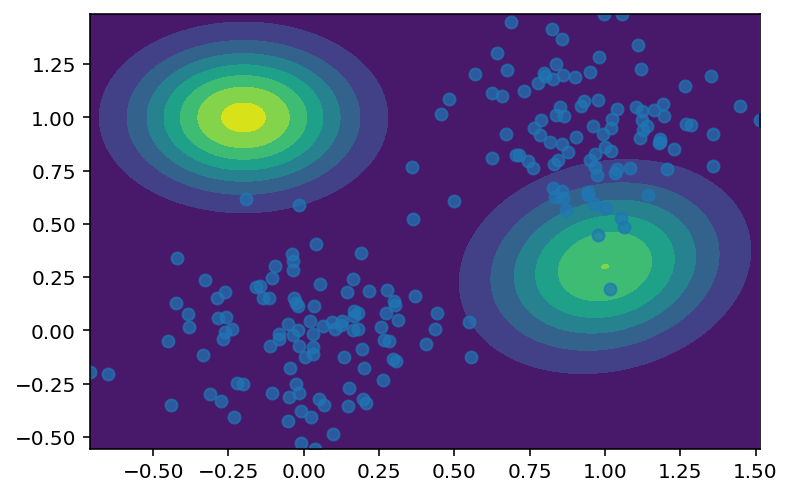

In [10]:
Norm1 = multivariate_normal(mean=mu1, cov=Sigma1)
Norm2 = multivariate_normal(mean=mu2, cov=Sigma2)

x0, y0 = X.min(axis=0)
x1, y1 = X.max(axis=0)

step = 0.01
xx, yy = np.mgrid[x0:x1:step, y0:y1:step]

density1 = np.c_[xx.ravel(), yy.ravel()]
density1 = Norm1.pdf(density1).reshape(xx.shape)

density2 = np.c_[xx.ravel(), yy.ravel()]
density2 = Norm2.pdf(density2).reshape(xx.shape)

density = pi1 * density1 + pi2 * density2

plt.contourf(xx, yy, density);
plt.scatter(*X.T, alpha=0.7)
plt.xlim(x0, x1)
plt.ylim(y0, y1);

In [11]:
from matplotlib.colors import ListedColormap

def compute_responsibilities(k, pi, mu, sigma):
    Ns = [multivariate_normal(mean=mu_i, cov=Sigma_i) for mu_i, Sigma_i in zip(mu, sigma)]
    def respons(x):
        elements = [pi_i * Ni.pdf(x) for pi_i, Ni in zip(pi, Ns)]
        return elements[k] / np.sum(elements, axis=0)
    return respons


def plot_mixtures(X, mu, pi, Sigma, r, step=0.01):
    colors = ["tab:red", "tab:blue"]
    cmap = ListedColormap(["tab:blue", "tab:red"])
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]
    
    Norms = [multivariate_normal(mean=mui, cov=Sigmai)
             for mui, Sigmai in zip(mu, Sigma)]
    
    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        plt.contour(xx, yy, density, levels=1,
                    colors=color, linewidths=5)
        
    plt.scatter(*X.T, alpha=0.7, c=r, cmap=cmap)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)

### E Step
Update of responsibilities

In [12]:
Sigma =  [Sigma1, Sigma2]
mu = [mu1, mu2]
pi = [pi1, pi2]

r1 = compute_responsibilities(0, pi, mu, Sigma)(X)
r2 = compute_responsibilities(1, pi, mu, Sigma)(X)

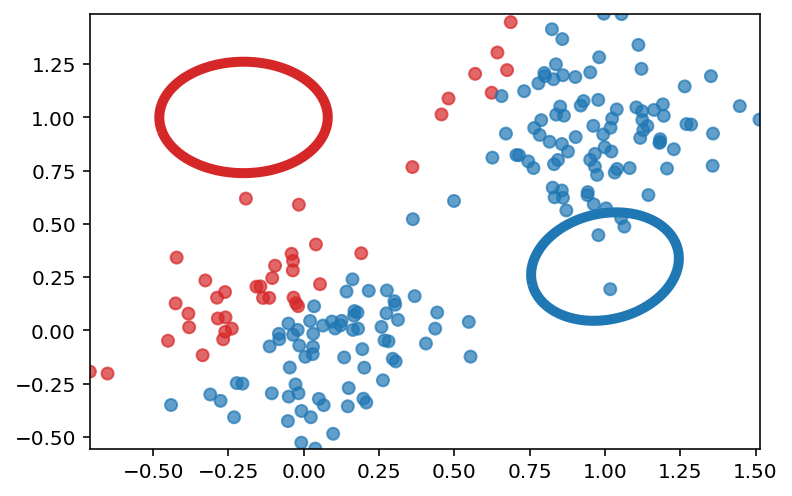

In [13]:
plot_mixtures(X, mu, pi, Sigma, r1)

### M Step
Update $\forall k. \pi_k, \mu_k, \Sigma_k$

In [14]:
N1, N2 = r1.sum(), r2.sum()

mu1 = (r1[:, np.newaxis] * X).sum(axis=0) / N1
mu2 = (r2[:, np.newaxis] * X).sum(axis=0) / N2

In [15]:
d1 = (X - mu1)

Sigma1 = r1[:, np.newaxis, np.newaxis] * np.einsum("ij,ik->ikj", d1, d1)
Sigma1 = Sigma1.sum(axis=0) / N1

In [16]:
d2 = (X - mu2)
Sigma2 = r2[:, np.newaxis, np.newaxis] * np.einsum("ij,ik->ikj", d2, d2)
Sigma2 = Sigma2.sum(axis=0) / N2

In [17]:
pi1 = N1 / N
pi2 = N2 / N

### E-step (Second update of responsibilities)

In [18]:
Sigma =  [Sigma1, Sigma2]
mu = [mu1, mu2]
pi = [pi1, pi2]

r1 = compute_responsibilities(0, pi, mu, Sigma)(X)
r2 = compute_responsibilities(1, pi, mu, Sigma)(X)

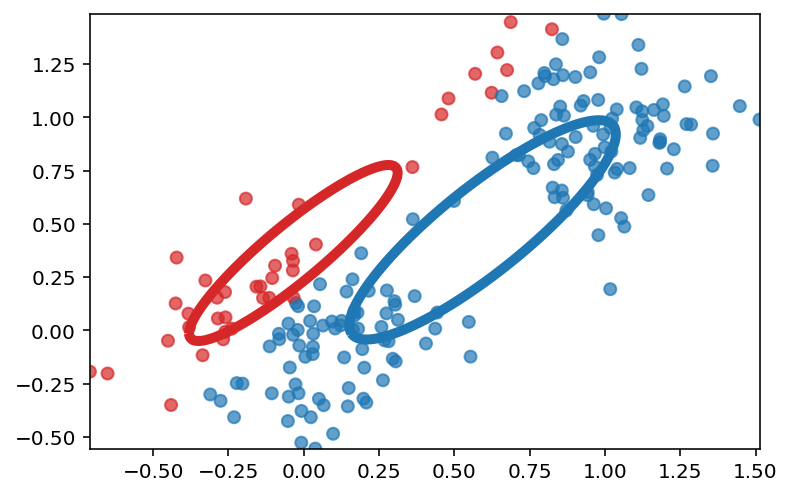

In [19]:
plot_mixtures(X, mu, pi, Sigma, r1)

## Implementation

In [20]:
def e_step(pi, mu, Sigma):
    responsibilities = []
    for i, _ in enumerate(mu):
        resp_k = compute_responsibilities(i, pi, mu, Sigma)
        responsibilities.append(resp_k)
    return responsibilities

def m_step(X, responsibilities):
    N, M = X.shape
    pi, mu, Sigma = [], [], []
    for resp_k in responsibilities:
        resp_k = resp_k(X)
        Nk = resp_k.sum()
        # mu_k
        mu_k = (resp_k[:, np.newaxis] * X).sum(axis=0) / Nk
        # Sigma_k
        dk = (X - mu_k)
        Sigma_k = resp_k[:, np.newaxis, np.newaxis] * np.einsum("ij, ik->ikj", dk, dk)
        Sigma_k = Sigma_k.sum(axis=0) / Nk
        # pi_k
        pi_k = Nk / N
        
        pi.append(pi_k)
        mu.append(mu_k)
        Sigma.append(Sigma_k)
    return pi, mu, Sigma

def gmm_log_likelihood(X, pi, mu, sigma):
    likelihood =  0
    for pi_k, mu_k, Sigma_k in zip(pi, mu, Sigma):
        norm_k = multivariate_normal(mean=mu_k, cov=Sigma_k)
        likelihood += pi_k * norm_k.pdf(X)
    return np.log(likelihood).sum()

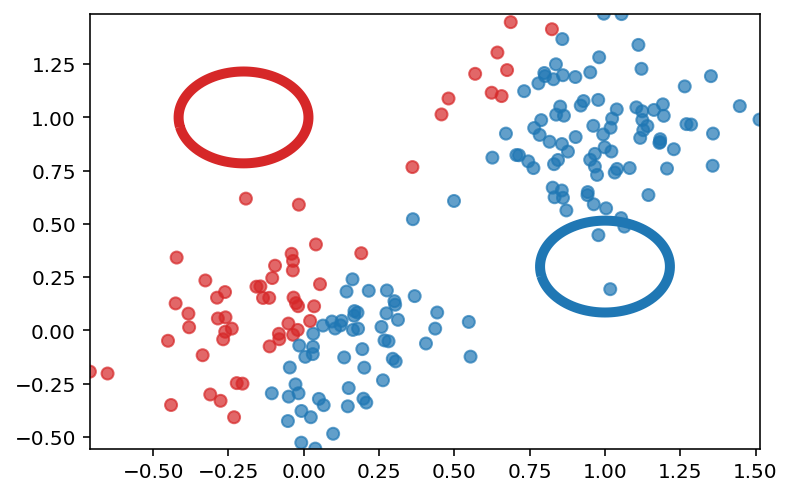

In [21]:
# Initial setup
mu1 = np.array([-0.2, 1])
mu2 = np.array([ 1, 0.3])

Sigma1 = np.identity(2) / 20
Sigma2 = np.identity(2) / 20

pi = [0.5, 0.5]
mu = [mu1, mu2]
Sigma = [Sigma1, Sigma2]
r = compute_responsibilities(0, pi, mu, Sigma)(X)

log_likelihood = gmm_log_likelihood(X, pi, mu, Sigma)
plot_mixtures(X, mu, pi, Sigma, r)

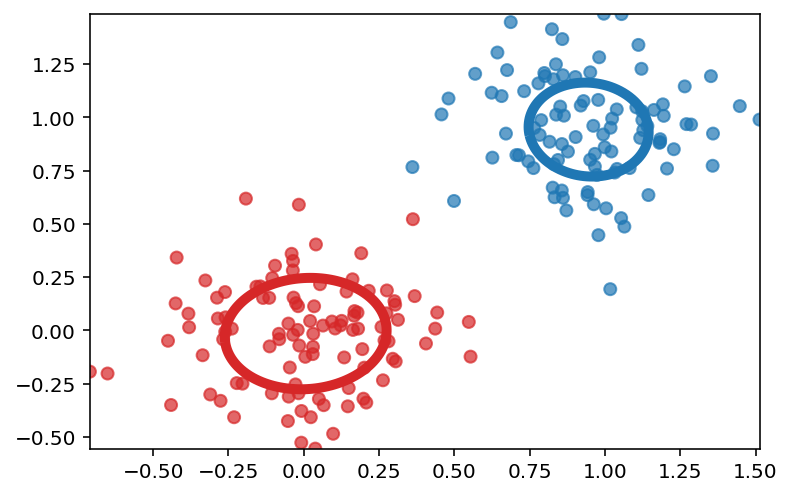

In [22]:
hist_log_likelihood = [log_likelihood]
hist_coeffs = [(pi, mu, Sigma)]
hist_responsibilities = [r]

while True:
    responsibilities = e_step(pi, mu, Sigma)
    pi, mu, Sigma = m_step(X, responsibilities)
    log_likelihood = gmm_log_likelihood(X, pi, mu, Sigma)
    
    hist_coeffs.append((pi, mu, Sigma))
    hist_responsibilities.append(responsibilities[0](X))
    hist_log_likelihood.append(log_likelihood)
    
    if np.abs(hist_log_likelihood[-1] / hist_log_likelihood[-2] - 1) < 1e-5:
        break
    
r = responsibilities[0](X)
plot_mixtures(X, mu, pi, Sigma, r)

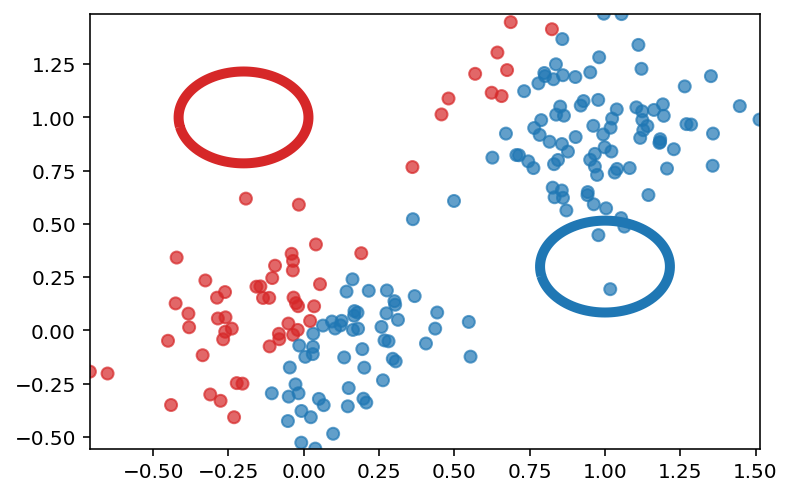

In [23]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

def animate(i):
    plt.cla()
    pi, mu, Sigma = hist_coeffs[i]
    r = hist_responsibilities[i]
    plot_mixtures(X, mu, pi, Sigma, r)
    
nits = len(hist_log_likelihood)
ani = animation.FuncAnimation(fig, animate, nits, interval=300)
ani.save("/Users/gerardoduran/Desktop/gmm.gif", fps=10, dpi=150, writer="imagemagick")